In [1]:
from collections.abc import Iterable
import numba as nb
import numpy as np
import matplotlib.pyplot as plt

### Оценка среднего расстояния, пройденного волной.

In [2]:
def _tus_from_args(storage, t_min, t_max, tus):
    if storage:
        tus = storage.load_tus(t_min=t_min, t_max=t_max)
    elif storage is None and tus is not None:
        idx = np.logical_and(tus[:, 0] >= t_min, tus[:, 0] <= t_max)
        tus = tus[idx]
    else:
        raise ValueError('Neither storage nor tus is specified.')
    return tus

In [3]:
@nb.njit('f8(f8[:, :])')
def integrate_trapeze(tus):
    res = 0.
    for i in range(1, tus.shape[0]):
        res += (tus[i, 1] + tus[i - 1, 1]) * (tus[i, 0] - tus[i - 1, 0])
    res *= 0.5
    return res

In [4]:
@nb.njit
def _find_minima_idx(tus):
    idx = []
    i = 0
    while i < tus.shape[0] - 2:
        i += 1
        while not (tus[i - 1, 1] > tus[i, 1] < tus[i + 1, 1]) and i + 1 < tus.shape[0] - 1:
            i += 1
        idx.append(i)
    if idx:
        idx.pop()
    return np.array(idx)

In [5]:
def find_minima(storage=None, t_min=1000, t_max=np.inf,
                plot=False, ret_idx=False, main=False, tus=None):
    '''Finds points of tus with minimal us'''
    tus = _tus_from_args(storage, t_min, t_max, tus)
    idx = _find_minima_idx(tus)
    minima = tus[idx, :]
    if main:
        ptp = minima[minima[:, 0] >= 1000, 1].ptp()
        if ptp > 5e-4:
            while True:
                minima_next, idx_next = \
                    find_minima(tus=minima, t_min=t_min, t_max=t_max, ret_idx=True)
                if np.unique(minima_next[:, 1]).size < 2 or ptp < 5e-6:
                    break
                minima, idx = minima_next, idx[idx_next]
                ptp = minima_next[:, 1].ptp()
    if plot:
        plt.plot(tus[:, 0], tus[:, 1])
        plt.gcf().set_size_inches((10, 5))
        plt.grid()
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        plt.scatter(minima[:, 0], minima[:, 1], c='red', marker='x')
    if ret_idx:
        return minima, idx
    return minima

In [6]:
def estimate_mean(storage=None, t_min=1000, t_max=np.inf, what='speed',
                  int_periods=False, verbose=False, tus=None):
    '''min - estimate mean minimum'''
    if what == 'speed':
        tus = _tus_from_args(storage, t_min, t_max, tus)
        if int_periods:
            idx = _find_minima_idx(tus)
            tus = tus[idx[0] : idx[-1] + 1, :]
        interval = tus[-1, 0] - tus[0, 0]
        mean = integrate_trapeze(tus) / interval
    elif what == 'min':
        minima = find_minima(storage, t_min, t_max, tus=tus)
        mean = minima[:, 1].mean()
    elif what == 'minmin':
        minima = find_minima(storage, t_min, t_max, main=True, tus=tus)
        mean = minima[:, 1].mean()
    else:
        raise ValueError('Wrong value for `what`')
    return mean

### Преобразование Фурье

In [7]:
def estimate_harmonics(storage=None, t_min=1000, t_max=np.inf, plot=False, tuszz=None):
    minima = find_minima(storage, t_min, t_max, tus=tus)
    minima_t, minima_us = minima[:, 0], minima[:, 1]
    main_mins_t = minima[np.isclose(minima_us, minima_us.min(), 
                                    atol=1e-5, rtol=1e-5), 0]
    if main_mins_t.size == minima_t.size:  # simple period
        return (minima_t.size - 1) / minima_t.ptp()
    if main_mins_t.size == 1:  # signal seems to be chaotic
        return
    f1 = (main_mins_t.size - 1) / main_mins_t.ptp()
    minima_bm = minima_t[  # between main, inclusive
        np.logical_and(minima_t >= main_mins_t[0], minima_t <= main_mins_t[-1])
    ]
    f2 = (minima_bm.size - 1) / minima_bm.ptp()
    if not plot:
        return f1, f2

In [8]:
def f_plot_lim(f, y):
    y_is_small = np.isclose(y, 0, atol=y.max() / 200)
    # find index of the last observable y
    if not y_is_small[-1]:
        return f[-1]
    i = 1
    while y_is_small[-i]:
        i += 1
    i += 1
    if i < 100:
        return f[-1]
    else:
        f_lo = f[-i]  # last observable
        return f_lo * 1.1

In [9]:
def nudft(t, x, M, df=1.0):
    """Non-Uniform Direct Fourier Transform"""
    freqs = df * np.arange(M)
    y = np.dot(x.astype(np.complex128),
               np.exp(2j * np.pi * freqs * t[:, np.newaxis]))
    return freqs, y

In [10]:
def power_spectrum(storage=None, t_min=1000, t_max=2000, M=1000,
                   df=0.1, log_scale=False, plot=True, tus=None):
    tus = _tus_from_args(storage, t_min, t_max, tus)
    t, us = tus[:, 0], tus[:, 1] - estimate_mean(storage, t_min, t_max, tus=tus)
    f, y = nudft(t, us, M, df)
    np.abs(y, out=y)
    y = y.real
    y[np.isclose(f, 0)] = 0
    if log_scale:
        y = 20 * np.log10(y)
    
    fig, ax = plt.subplots(2, 1)
    fig.set_size_inches((12, 8))
    ax[0].plot(t, us)
    ax[0].grid()
    ax[1].plot(f, y)
    ax[1].minorticks_on()
    ax[1].grid(which='major', linestyle='-', color='0.4')
    ax[1].grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    ax[1].set_xlim(0, f_plot_lim(f, y))
    ax[1].set_ylim(bottom=0)
    return f, y

### Оценка волнового числа, приводящего к резонансу

In [11]:
def is_steady(storage=None, tus=None, minima=None):
    '''If there is a steady case, then the minima increase over time,
    otherwise they decrease.'''
    if minima is None:
        minima = find_minima(storage, t_min=0, tus=None)
    if minima[0, 1] < minima[-1, 1]:
        return True
    return False

In [12]:
def resonant_wn(storage=None, precision=5,
                tus=None, amp=None):
    '''
    estimates wave number of u_a expected to produce resonance
    
    function loads data from filename, integrates Dshock over time > t_stable 
    between two consequent minimums of u_s
    '''
    if storage:
        amp = storage.amp
        if storage.wn:
            storage.set(wn=None)
    elif amp is None:
        raise ValueError('amp is not specified.')

    minima = find_minima(storage, 0, tus=tus)
    if is_steady(storage, tus, minima):
        t_min = minima[0, 0]
        t_max = minima[1, 0]
    else:
        t_min = minima[-2, 0]
        t_max = minima[-1, 0]
    tus = _tus_from_args(storage, t_min, t_max, tus)
    tus[:, 1] += amp / (1 - amp)
    period = integrate_trapeze(tus)
    
    return round(2 * np.pi / period, precision)

/tmp/ipykernel_119457/265460163.py:10: RuntimeWarning: divide by zero encountered in log10
  y = 20 * np.log10(y)


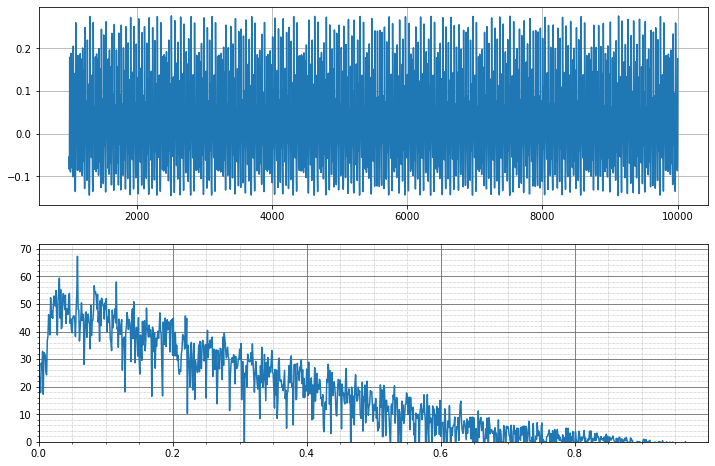

In [27]:
f, y = power_spectrum(tus=data_GT, t_min=1000, t_max=10000, M=1000, df=0.001, log_scale=True, plot=True)

/tmp/ipykernel_119457/265460163.py:10: RuntimeWarning: divide by zero encountered in log10
  y = 20 * np.log10(y)


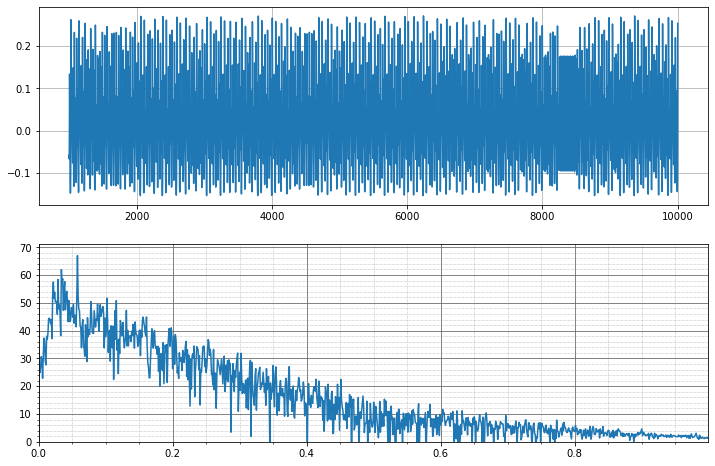

In [26]:
f, y = power_spectrum(tus=data_FNO, t_min=1000, t_max=10000, M=1000, df=0.001, log_scale=True, plot=True)

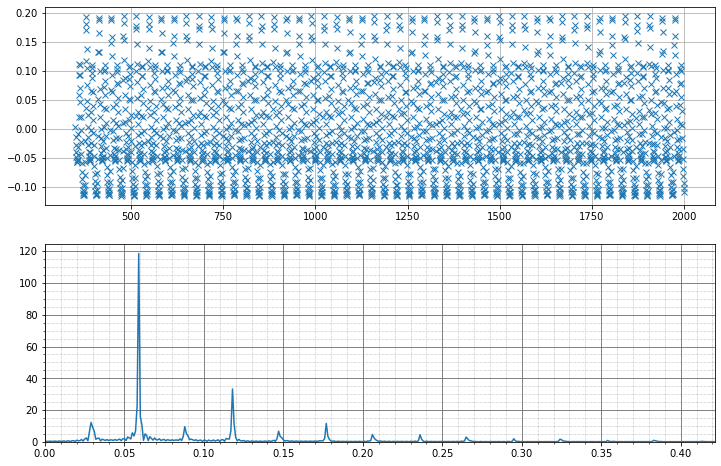

In [389]:
f, y = power_spectrum(tus=data_array, t_min=350, t_max=2000, M=1000, df=0.001, log_scale=False, plot=True)

In [13]:
data_full = np.load('u_original_5.1_10000.npy', allow_pickle=True)

In [14]:
init_solve = np.load('u_original_5.1_350.npy', allow_pickle=True)[::20,-1]

In [15]:
time = np.load('time_5.1_10000.npy', allow_pickle=True)[-1]

In [16]:
FNO = np.load('FNO_shockarray_5.1_20.npy', allow_pickle=True)[:,-1]

(9000.0, 10000.0)

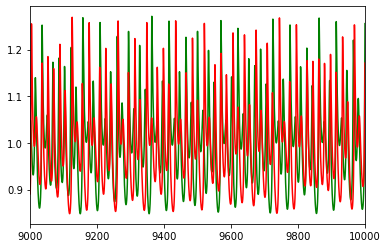

In [25]:
plt.plot(time,data_fine,'g')
plt.plot(time,data_full[:,-1],'r')
plt.xlim([9000,10000])

In [18]:
data = np.append(init_solve,FNO)

In [19]:
time_gap = time[::20]

In [20]:
from scipy import interpolate

tck = interpolate.splrep(time_gap, data, s = 0)

data_fine = interpolate.splev(time, tck, der=0)

In [21]:
data_full.shape

(212103, 207)

In [22]:
data_fine.shape

(212103,)

In [23]:
data_FNO = np.array([time[:],data_fine]).T

In [24]:
data_GT = np.array([time[:],data_full[:,-1]]).T

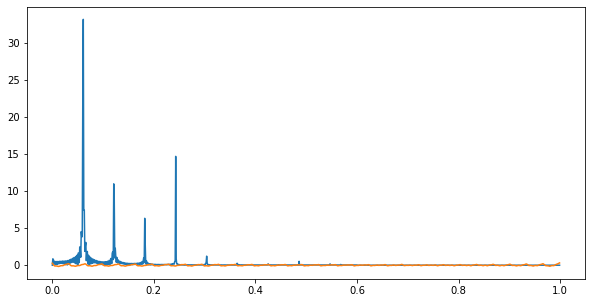

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftfreq, irfft, rfft

cut_f_signal = y
cut_f_signal[(np.abs(f)>0.6)] = 0 # cut signal above 3Hz

cs = irfft(cut_f_signal)

fig = plt.figure(figsize=(10,5))
plt.plot(f, y)
plt.plot(f, cs)

In [311]:
d = rfft(data)

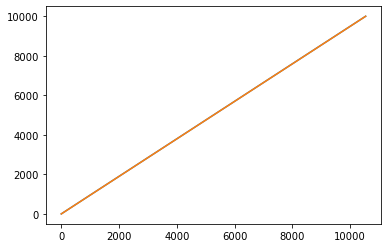

In [312]:
plt.plot(d)